In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction

--------------------------------------------------------------
# Load data
--------------------------------------------------------------

In [2]:
df = pd.read_pickle('../../data/interim/02_outliers_removed_chauvenet.pkl')
predictor_columns = list(df.columns[:6])

In [3]:
# plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2

--------------------------------------------------------------
# Dealing with missing values (imputation)
--------------------------------------------------------------

In [4]:
for col in predictor_columns:
    df[col] = df[col]. interpolate()

--------------------------------------------------------------
# Calculating set duration
--------------------------------------------------------------

In [5]:
for s in df['set'].unique():
    start = df[df['set'] == s].index[0]
    stop = df[df['set'] == s].index[-1]
    duration = stop - start
    df.loc[(df['set'] == s), 'duration'] = duration.seconds

In [6]:
duration_df = df.groupby(['category'])['duration'].mean()
duration_df

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [8]:
print(duration_df.iloc[0] / 5)
print(duration_df.iloc[1] / 10)

2.9487001733102254
2.4942528735632186


--------------------------------------------------------------
# Butterworth lowpass filter
--------------------------------------------------------------

In [19]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

In [18]:
fs = 1000 / 200
cutoff = 1.25

df_lowpass = LowPass.low_pass_filter(df_lowpass, 'acc_y', fs, cutoff, order = 5)
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,bench,heavy,B,30,16.0,0.977016
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,bench,heavy,B,30,16.0,0.973058
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,bench,heavy,B,30,16.0,0.965123
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,bench,heavy,B,30,16.0,0.962422
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,bench,heavy,B,30,16.0,0.963387
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,row,medium,E,90,19.0,-0.980824
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,row,medium,E,90,19.0,-1.039622
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,row,medium,E,90,19.0,-1.048628


ohp


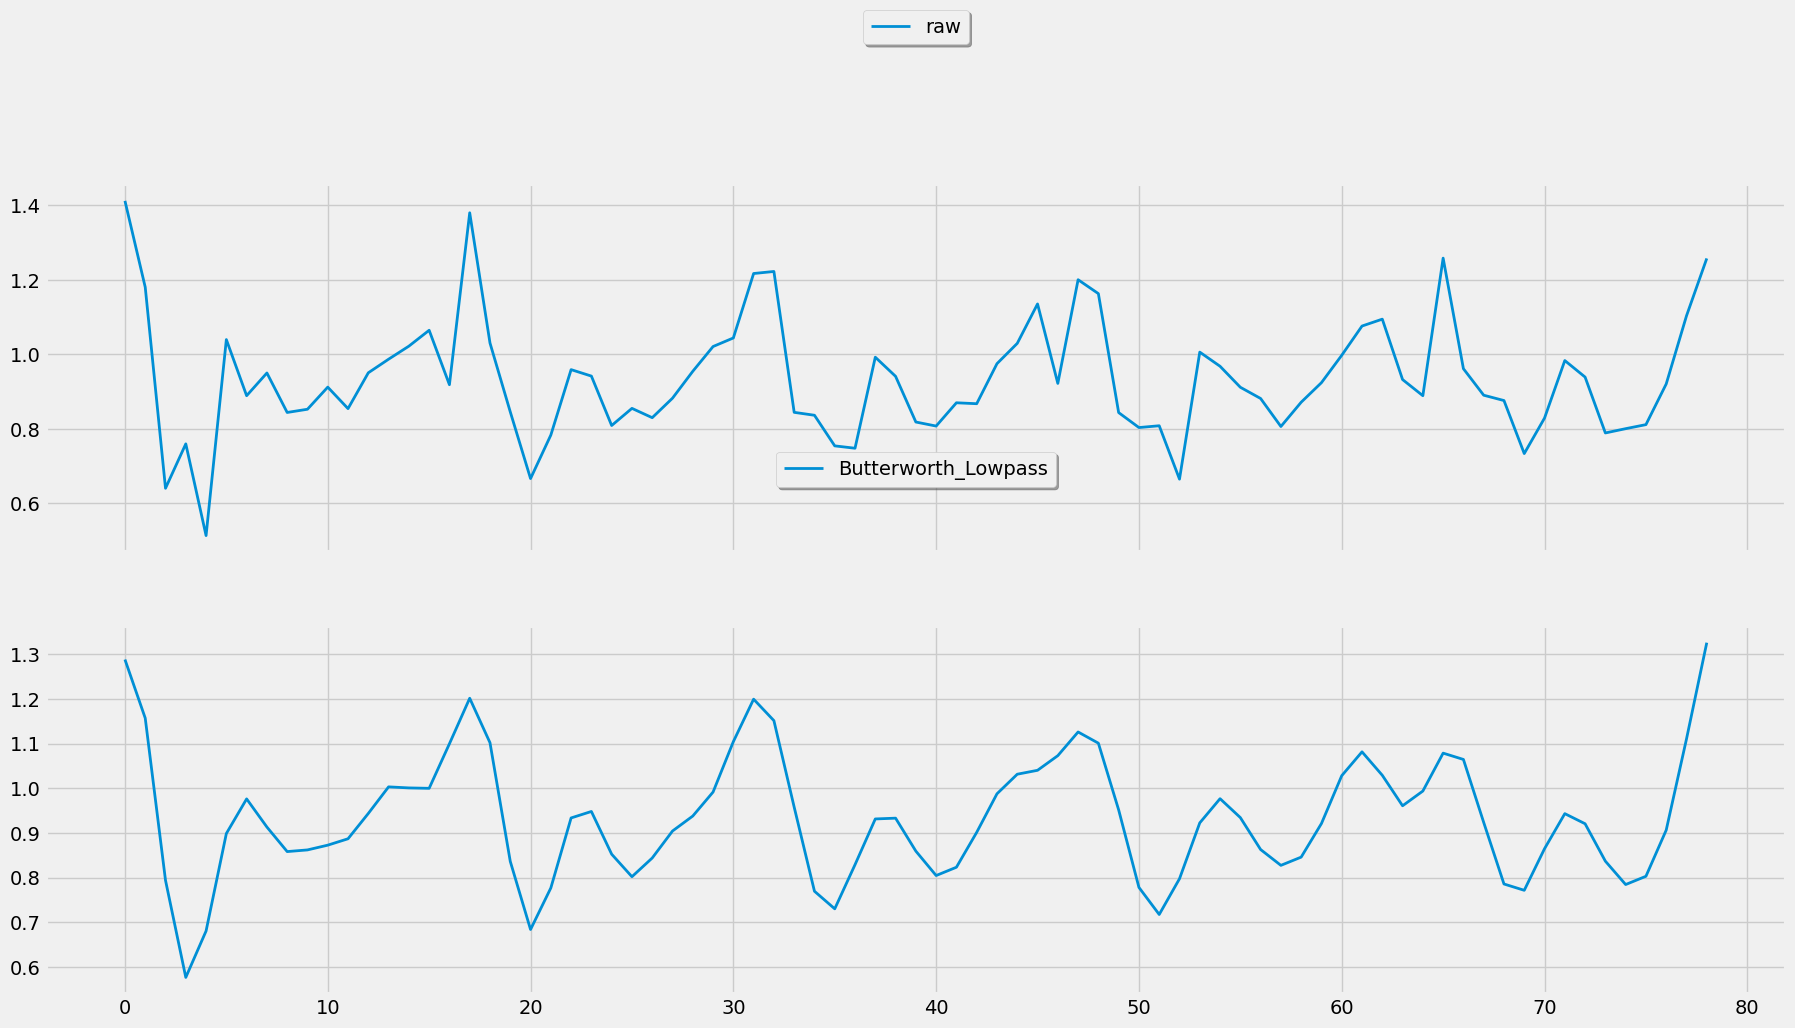

In [16]:
subset = df_lowpass[df_lowpass['set'] == 45]
print(subset['label'][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize = (20,10))
ax[0].plot(subset['acc_y'].reset_index(drop = True), label = 'raw')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop = True), label = 'Butterworth_Lowpass')
ax[0].legend(loc = 'upper center', bbox_to_anchor = (0.5,1.5), fancybox = True, shadow = True)
ax[1].legend(loc = 'upper center', bbox_to_anchor = (0.5,1.5), fancybox = True, shadow = True)

In [21]:
df_lowpass = df.copy()

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order = 5)
    df_lowpass[col] = df_lowpass[col + '_lowpass']
    del df_lowpass[col + '_lowpass']

df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013493,0.977016,-0.071001,-1.895512,2.437133,0.940748,bench,heavy,B,30,16.0
2019-01-11 15:08:05.400,0.007992,0.973058,-0.066513,0.899845,0.472271,-0.599037,bench,heavy,B,30,16.0
2019-01-11 15:08:05.600,-0.008917,0.965123,-0.072614,4.268261,-2.066298,-1.100413,bench,heavy,B,30,16.0
2019-01-11 15:08:05.800,-0.023902,0.962422,-0.084710,3.416969,-3.520616,0.139319,bench,heavy,B,30,16.0
2019-01-11 15:08:06.000,-0.021281,0.963387,-0.095423,0.883263,-1.244395,-1.983523,bench,heavy,B,30,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.044249,-0.980824,-0.062005,2.537614,-4.220733,0.207296,row,medium,E,90,19.0
2019-01-20 17:33:27.200,-0.041867,-1.039622,-0.061381,-2.924296,-2.470034,1.421960,row,medium,E,90,19.0
2019-01-20 17:33:27.400,-0.047515,-1.048628,-0.066242,-0.289311,-1.933288,1.151634,row,medium,E,90,19.0


--------------------------------------------------------------
# Principal component analysis PCA
--------------------------------------------------------------

In [22]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

In [24]:
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

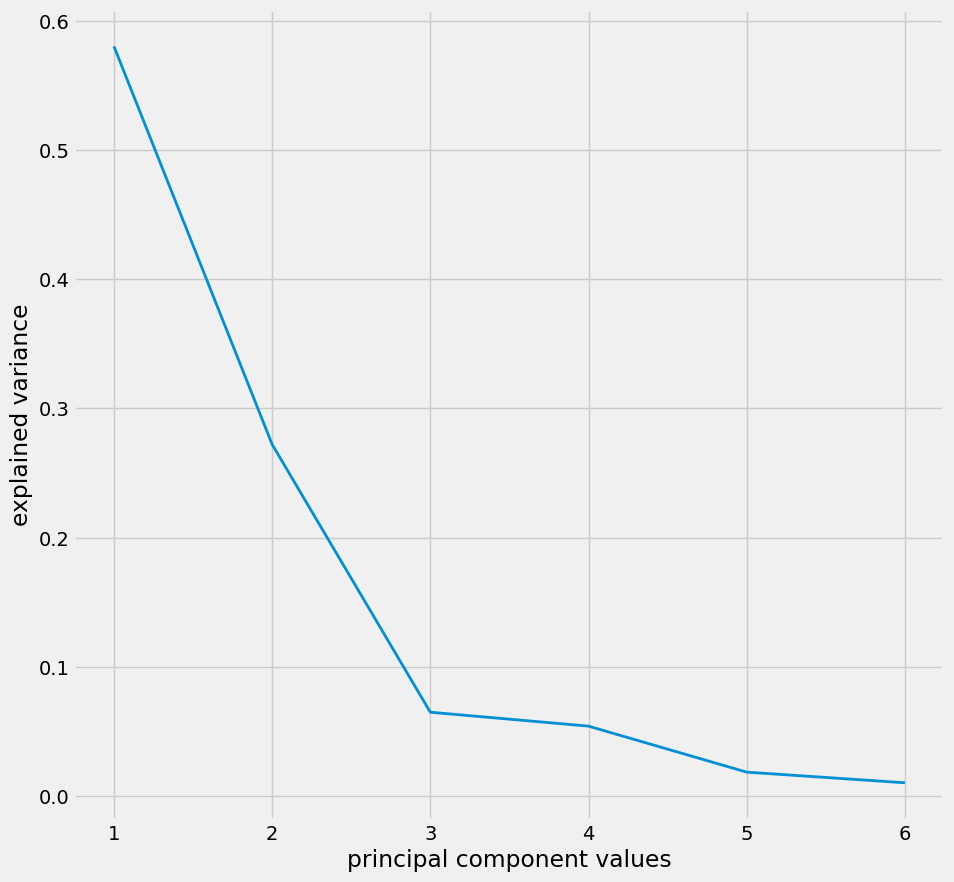

In [25]:
plt.figure(figsize=(10,10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel('principal component values')
plt.ylabel('explained variance')
plt.show()

In [26]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

<AxesSubplot: xlabel='epoch (ms)'>

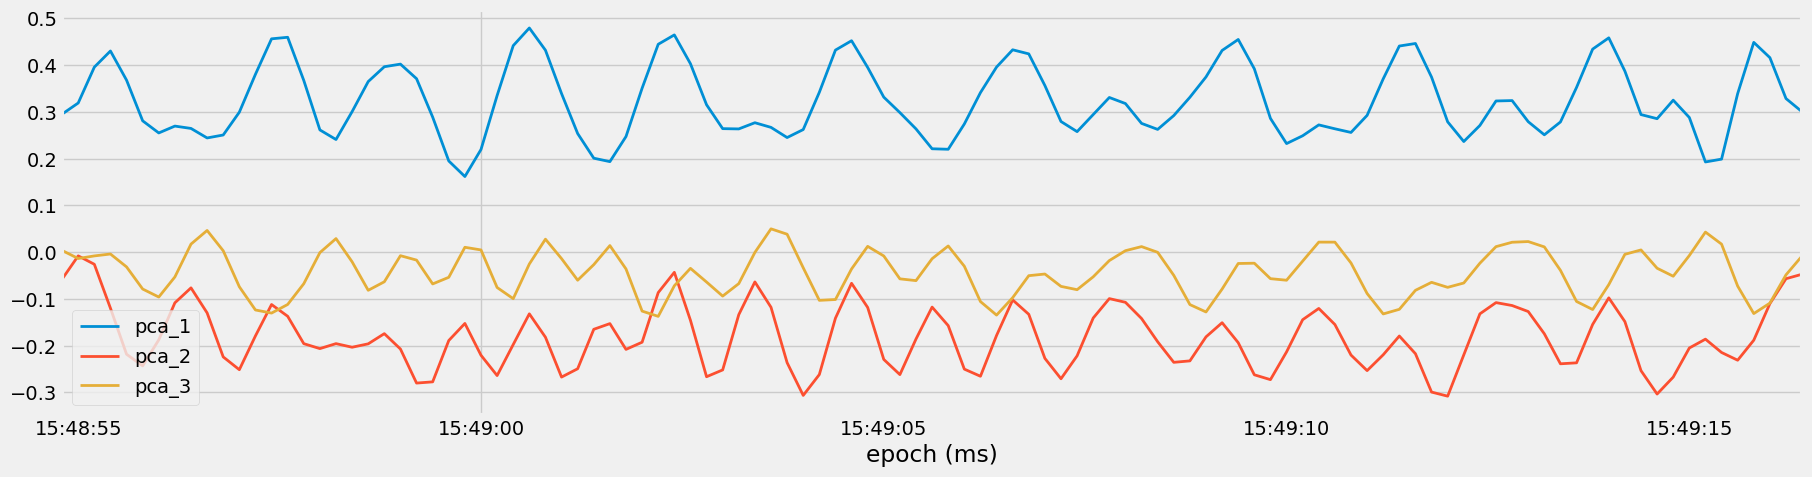

In [27]:
subset = df_pca[df_pca['set'] == 35]
subset[['pca_1','pca_2','pca_3']].plot()